# Food Vision end-to-end project

Goal of this project is to create model that can beat original DeepFood [paper](https://arxiv.org/ftp/arxiv/papers/1606/1606.05675.pdf) and it's 77,4% accuracy. 

In [2]:
# !pip install tfds-nightly 
import tensorflow_datasets as tfds
import tensorflow as tf
import utils
from tensorflow.keras import layers, applications, Model


## Data

We'll use full verision of food101, in previous notebooks we're using only parts of the data and increased complexity as needed. Now we are going to use everything we have.

In [4]:
# Load in the data (takes ~5mins in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101", split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data, label) 
                                             with_info=True
                                             )

In [3]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [4]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [5]:
# Check single sample
sample = train_data.take(1)
sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [6]:
# Output info about our training sample
for image, label in sample:
    print(image.shape)
    print(image.dtype)
    print(label)
    print(class_names[label.numpy()])

(512, 512, 3)
<dtype: 'uint8'>
tf.Tensor(77, shape=(), dtype=int64)
pork_chop


In [7]:
# What does image tensor from tfds's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 64,  27,  11],
        [ 73,  36,  20],
        [ 83,  46,  28],
        ...,
        [150, 105,  82],
        [138,  93,  72],
        [134,  89,  68]],

       [[ 69,  32,  16],
        [ 70,  33,  17],
        [ 72,  35,  17],
        ...,
        [155, 110,  87],
        [141,  96,  75],
        [135,  90,  69]],

       [[ 71,  35,  19],
        [ 65,  29,  13],
        [ 61,  26,   7],
        ...,
        [162, 118,  93],
        [144, 102,  78],
        [137,  95,  71]],

       ...,

       [[210,  82,  21],
        [208,  80,  19],
        [205,  77,  14],
        ...,
        [223, 172, 115],
        [226, 175, 118],
        [224, 173, 116]],

       [[199,  71,   8],
        [199,  71,   8],
        [198,  70,   7],
        ...,
        [224, 173, 116],
        [226, 175, 118],
        [223, 172, 115]],

       [[204,  76,  13],
        [204,  76,  13],
        [203,  75,  12],
        ...,
        [225, 174, 11

In [8]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image

In [9]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.axis(False);

### Preprocessing

We know what images are not normalized, have different sizes and have `uint8` dtype. We have to deal with it. Also we need split data into batches.

Normalization will be done by built-in layer of EfficientNetBx.

In [5]:
def preprocess_img(image, label, img_shape=(224,224)):
  """
  Converts dtype of image 'uint8' -> 'float32' and reshapes image to [img_shape].
  Converts dtype of label to float32.
  """
  image = tf.image.resize(image, img_shape),
  return tf.squeeze(tf.cast(image, tf.float32)), tf.cast(label, tf.float32)

In [11]:
# Preprocess a single image
preprocess_img(image, label)

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[ 69.69388  ,  32.69388  ,  16.693878 ],
         [ 78.44898  ,  41.44898  ,  22.520409 ],
         [ 78.35204  ,  42.566326 ,  16.137754 ],
         ...,
         [211.34154  , 166.91301  , 141.69875  ],
         [172.38239  , 127.382385 , 104.382385 ],
         [138.04063  ,  93.040634 ,  72.040634 ]],
 
        [[ 63.693874 ,  28.290815 ,  10.499998 ],
         [ 60.137756 ,  25.137754 ,   3.2857132],
         [ 68.54082  ,  33.484695 ,   5.198978 ],
         ...,
         [208.20901  , 164.19371  , 136.76518  ],
         [184.3518   , 140.48448  , 113.76002  ],
         [146.6731   , 104.673096 ,  79.74452  ]],
 
        [[ 62.142857 ,  30.142857 ,   8.438776 ],
         [ 61.795918 ,  27.739798 ,   2.280612 ],
         [ 64.43878  ,  29.39286  ,   1.62245  ],
         ...,
         [160.42403  , 119.85259  ,  88.96486  ],
         [191.30092  , 150.72949  , 120.08663  ],
         [157.9994   , 118.999405 ,  87.57084 

In [6]:
#Map preprocessing funcion to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Repeat above for test set but without shuffling
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [13]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.float32)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.float32)>)

## Modeling

In [14]:
# Create callback

callbacks = [utils.create_checkpoint_callback("./checkpoints/08_food_vision/model_0/checkpoint.ckpt",
                                              best_only=True, weights_only=True),
             utils.create_tensorboard_callback("./logs/08_food_vision",
             "model_0_EffNetB0_base")]


Saving TensorBoard log files to: ./logs/08_food_vision/model_0_EffNetB0_base/20210921-134213


### Build feature extraction model

In [15]:
from tensorflow.keras import layers, applications, Model

def create_model():
  input_shape = (224,224,3)
  base_model = applications.EfficientNetB0(include_top=False)
  base_model.trainable = False
  
  inputs = layers.Input(shape=input_shape, dtype=tf.float32, name="input_layer")
  x = base_model(inputs, training=False)
  x = layers.GlobalAveragePooling2D()(x)

  outputs = layers.Dense(101, activation="softmax", dtype=tf.float32)(x)

  return Model(inputs, outputs)

In [16]:
model_0 = create_model()
# Compile the model
model_0.compile(
  optimizer="adam",
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])
  
#fit model
model_0.fit(train_data,
            epochs = 7,
            steps_per_epoch=len(train_data),
            validation_data=test_data,
            validation_steps=int(0.15 * len(test_data)),
            callbacks = callbacks,
            )

c:\MLandDS\tensorflow\env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/7
2368/2368 [==============================] - 193s 77ms/step - loss: 1.8233 - accuracy: 0.5570 - val_loss: 1.2313 - val_accuracy: 0.6849

Epoch 00001: val_accuracy improved from -inf to 0.68485, saving model to ./checkpoints/08_food_vision/model_0\checkpoint.ckpt
Epoch 2/7
2368/2368 [==============================] - 172s 72ms/step - loss: 1.2948 - accuracy: 0.6661 - val_loss: 1.1249 - val_accuracy: 0.6968

Epoch 00002: val_accuracy improved from 0.68485 to 0.69677, saving model to ./checkpoints/08_food_vision/model_0\checkpoint.ckpt
Epoch 3/7
2368/2368 [==============================] - 209s 88ms/step - loss: 1.1433 - accuracy: 0.7029 - val_loss: 1.0911 - val_accuracy: 0.7029

Epoch 00003: val_accuracy improved from 0.69677 to 0.70286, saving model to ./checkpoints/08_food_vision/model_0\checkpoint.ckpt
Epoch 4/7
2368/2368 [==============================] - 214s 90ms/step - loss: 1.0453 - accuracy: 0.7264 - val_loss: 1.0743 - val_accuracy: 0.7074

Epoch 00004: val_accuracy im

### Fine tune model with 6 layers

In [26]:
utils.create_model_for_fine_tuning(model_0, 6)

In [27]:
# Compile the model
model_0.compile(
  optimizer=tf.optimizers.Adam(0.0001),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

# Create callback
callbacks = [utils.create_checkpoint_callback("./checkpoints/08_food_vision/model_0/checkpoint.ckpt",
                                              best_only=True, weights_only=True),
             utils.create_tensorboard_callback("./logs/08_food_vision",
             "model_0_EffNetB0_FineTune6lrs")]

  
# fit model
model_0.fit(train_data,
            epochs = 14,
            steps_per_epoch=len(train_data),
            validation_data=test_data,
            validation_steps=int(0.15 * len(test_data)),
            callbacks = callbacks,
            initial_epoch=7
            )

Saving TensorBoard log files to: ./logs/08_food_vision/model_0_EffNetB0_FineTune6lrs/20210921-141824
Epoch 8/14


c:\MLandDS\tensorflow\env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


2368/2368 [==============================] - 914s 380ms/step - loss: 0.8053 - accuracy: 0.7789 - val_loss: 0.8473 - val_accuracy: 0.7741

Epoch 00008: val_accuracy improved from -inf to 0.77410, saving model to ./checkpoints/08_food_vision/model_0\checkpoint.ckpt
Epoch 9/14
2368/2368 [==============================] - 964s 407ms/step - loss: 0.4849 - accuracy: 0.8631 - val_loss: 0.8857 - val_accuracy: 0.7675

Epoch 00009: val_accuracy did not improve from 0.77410
Epoch 10/14
2368/2368 [==============================] - 870s 367ms/step - loss: 0.2678 - accuracy: 0.9222 - val_loss: 0.9534 - val_accuracy: 0.7781

Epoch 00010: val_accuracy improved from 0.77410 to 0.77807, saving model to ./checkpoints/08_food_vision/model_0\checkpoint.ckpt
Epoch 11/14
2368/2368 [==============================] - 864s 365ms/step - loss: 0.1486 - accuracy: 0.9551 - val_loss: 1.0718 - val_accuracy: 0.7675

Epoch 00011: val_accuracy did not improve from 0.77807
Epoch 12/14
 634/2368 [=======>.................

KeyboardInterrupt: 

I stoped training since model's loss was decreasing in each epoch which is sign of overfiting.

In [28]:
# Load best weigths
model_0.load_weights("./checkpoints/08_food_vision/model_0/checkpoint.ckpt")

In [29]:
model_0.evaluate(test_data)

790/790 [==============================] - 52s 65ms/step - loss: 0.9446 - accuracy: 0.7691


[0.9445720911026001, 0.7691485285758972]

Our model is very close to 77% of accuracy. Which is good sign becasue I have a few aces up my sleeve.
Next, I'll create new model that take advantage of data augmentation and Dropout layers to fight with overfitting.

First I'll perform feature extraction on 10 epochs then, I'll add Fine Tuning on 6 layers for another 10 epochs.

### Feature extraction - augmented data + Dropout layer

#### Recreate data with data augmentation

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import utils
from tensorflow.keras import layers, applications, Model



def create_train_data_aug(data):
    data_aug = utils.create_data_aug_layer()
    train_data = data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
    train_data = train_data.shuffle(buffer_size=1000)
    train_data = train_data.batch(batch_size=32)
    train_data = train_data.map(lambda x, y: (data_aug(x, training=True), y),
                                num_parallel_calls=tf.data.AUTOTUNE)
    train_data =train_data.prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_data



In [4]:
(train_data, test_data), ds_info = tfds.load(name="food101", split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data, label) 
                                             with_info=True
                                             )
train_data = create_train_data_aug(train_data)
# process of creating test data remain the same
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

I added data augmentation process as part of creating data batches instead of putting it as part of the model, because it's way faster that way.

In [3]:
from tensorflow.keras import layers, applications, Model

def create_model_dropouts():
    input_shape = (224,224,3)
    base_model = applications.EfficientNetB0(include_top=False)
    base_model.trainable = False

    inputs = layers.Input(shape=input_shape, dtype=tf.float32, name="input_layer")
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x, training=True)
    outputs = layers.Dense(101, activation="softmax")(x)

    return Model(inputs, outputs)

In [59]:
model_1 = create_model_dropouts()

In [60]:
# Compile the model
model_1.compile(
  optimizer=tf.optimizers.Adam(0.001),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

# Create callback
callbacks = [utils.create_checkpoint_callback("./checkpoints/08_food_vision/model_1/checkpoint.ckpt",
                                              best_only=True, weights_only=True),
             utils.create_tensorboard_callback("./logs/08_food_vision",
             "model_1_EffNetB0_DataAug_dropouts")]

  
# fit model
model_1.fit(train_data,
            epochs = 10,
            steps_per_epoch=len(train_data),
            validation_data=test_data,
            validation_steps=int(0.15 * len(test_data)),
            callbacks = callbacks
            )

Saving TensorBoard log files to: ./logs/08_food_vision/model_1_EffNetB0_DataAug_dropouts/20210921-160756


c:\MLandDS\tensorflow\env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/10
2368/2368 [==============================] - 431s 179ms/step - loss: 2.3698 - accuracy: 0.4313 - val_loss: 1.5279 - val_accuracy: 0.5951

Epoch 00001: val_accuracy improved from -inf to 0.59507, saving model to ./checkpoints/08_food_vision/model_1\checkpoint.ckpt
Epoch 2/10
2368/2368 [==============================] - 263s 111ms/step - loss: 1.9223 - accuracy: 0.5172 - val_loss: 1.4508 - val_accuracy: 0.6110

Epoch 00002: val_accuracy improved from 0.59507 to 0.61096, saving model to ./checkpoints/08_food_vision/model_1\checkpoint.ckpt
Epoch 3/10
2368/2368 [==============================] - 261s 110ms/step - loss: 1.8364 - accuracy: 0.5367 - val_loss: 1.4139 - val_accuracy: 0.6136

Epoch 00003: val_accuracy improved from 0.61096 to 0.61361, saving model to ./checkpoints/08_food_vision/model_1\checkpoint.ckpt
Epoch 4/10
2368/2368 [==============================] - 217s 91ms/step - loss: 1.7910 - accuracy: 0.5478 - val_loss: 1.4071 - val_accuracy: 0.6189

Epoch 00004: val_accu

### Fine tuning - augmented data + Dropout layer

#### 6 layers

In [62]:
utils.create_model_for_fine_tuning(model_1, 6)

In [65]:
# Compile the model
model_1.compile(
  optimizer=tf.optimizers.Adam(0.0001),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

# Create callback
callbacks = [utils.create_checkpoint_callback("./checkpoints/08_food_vision/model_1/checkpoint.ckpt",
                                              best_only=True, weights_only=True),
             utils.create_tensorboard_callback("./logs/08_food_vision",
             "model_1_EffNetB0_DataAug_dropouts_tuning6lrs")]

  
# fit model
model_1.fit(train_data,
            epochs = 20,
            steps_per_epoch=len(train_data),
            validation_data=test_data,
            validation_steps=int(0.5 * len(test_data)),
            callbacks = callbacks,
            initial_epoch = 18
            )

Saving TensorBoard log files to: ./logs/08_food_vision/model_1_EffNetB0_DataAug_dropouts_tuning6lrs/20210921-185249
Epoch 19/20
 518/2368 [=====>........................] - ETA: 10:06 - loss: 0.5021 - accuracy: 0.8529

ResourceExhaustedError:  failed to allocate memory
	 [[node Adam/gradients/sub (defined at <ipython-input-65-5e212eba2d9a>:15) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_355452]

Function call stack:
train_function


Model started crashing after 7 epochs. I had to restart kernel due to lack of memory. After a little bit of training accuracy stoped increasing. This experiment basically showed me that Data augmentation is waste of time and computing power.

In [9]:
model_1 = create_model_dropouts()
utils.create_model_for_fine_tuning(model_1, 6)
# Compile the model
model_1.compile(
  optimizer=tf.optimizers.Adam(0.0001),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

# Create callback
callbacks = [utils.create_checkpoint_callback("./checkpoints/08_food_vision/model_1/checkpoint.ckpt",
                                              best_only=True, weights_only=True),
             utils.create_tensorboard_callback("./logs/08_food_vision",
             "model_1_EffNetB0_DataAug_dropouts_tuning6lrs")]



model_1.load_weights("./checkpoints/08_food_vision/model_1_before_crash/checkpoint.ckpt")

Saving TensorBoard log files to: ./logs/08_food_vision/model_1_EffNetB0_DataAug_dropouts_tuning6lrs/20210922-083941


In [7]:
model_1.evaluate(test_data)

790/790 [==============================] - 76s 83ms/step - loss: 0.8719 - accuracy: 0.7665


[0.8718553781509399, 0.7664554715156555]

### Feature extraction - with dropouts dropouts, no data aug 

#### Re-create data pipelines without data aug

In [3]:
def preprocess_img(image, label, img_shape=(224,224)):
  """
  Converts dtype of image 'uint8' -> 'float32' and reshapes image to [img_shape].
  Converts dtype of label to float32.
  """
  image = tf.image.resize(image, img_shape),
  return tf.squeeze(tf.cast(image, tf.float32)), tf.cast(label, tf.float32)
# Load in the data 
(train_data, test_data), ds_info = tfds.load(name="food101", split=["train", "validation"],
                                             shuffle_files=False,
                                             as_supervised=True, # data gets returned in tuple format (data, label) 
                                             with_info=True
                                             )
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

#### Create and fit the model

In [24]:
model_2 = create_model_dropouts()
# Compile the model
model_2.compile(
  optimizer=tf.optimizers.Adam(0.001),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

# Create callback
callbacks = [utils.create_checkpoint_callback("./checkpoints/08_food_vision/model_2/checkpoint.ckpt",
                                              best_only=True, weights_only=True),
             utils.create_tensorboard_callback("./logs/08_food_vision",
             "model_2_EffNetB0_dropouts")]

Saving TensorBoard log files to: ./logs/08_food_vision/model_2_EffNetB0_dropouts/20210922-103152


In [25]:
# fit model
model_2.fit(train_data,
            epochs = 10,
            steps_per_epoch=len(train_data),
            validation_data=test_data,
            validation_steps=int(0.5 * len(test_data)),
            callbacks = callbacks
            )

Epoch 1/10
2368/2368 [==============================] - 232s 94ms/step - loss: 1.9600 - accuracy: 0.5236 - val_loss: 1.3631 - val_accuracy: 0.6426

Epoch 00001: val_accuracy improved from -inf to 0.64256, saving model to ./checkpoints/08_food_vision/model_2\checkpoint.ckpt
Epoch 2/10
2368/2368 [==============================] - 193s 81ms/step - loss: 1.4639 - accuracy: 0.6248 - val_loss: 1.2739 - val_accuracy: 0.6619

Epoch 00002: val_accuracy improved from 0.64256 to 0.66195, saving model to ./checkpoints/08_food_vision/model_2\checkpoint.ckpt
Epoch 3/10
2368/2368 [==============================] - 207s 87ms/step - loss: 1.3527 - accuracy: 0.6478 - val_loss: 1.2577 - val_accuracy: 0.6610

Epoch 00003: val_accuracy did not improve from 0.66195
Epoch 4/10
2368/2368 [==============================] - 207s 87ms/step - loss: 1.2959 - accuracy: 0.6594 - val_loss: 1.2623 - val_accuracy: 0.6601

Epoch 00004: val_accuracy did not improve from 0.66195
Epoch 5/10
2368/2368 [=====================

#### Recreate experiment using  ReduceLROnPlateau callback

In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
model_2 = create_model_dropouts()
# Compile the model
model_2.compile(
  optimizer=tf.optimizers.Adam(0.001),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

# Create callback
callbacks = [utils.create_checkpoint_callback("./checkpoints/08_food_vision/model_2/checkpoint.ckpt",
                                              best_only=True, weights_only=True),
             utils.create_tensorboard_callback("./logs/08_food_vision",
             "model_2_EffNetB0_dropouts_LRonPLat"),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=0, min_lr=0.000001,
                             verbose=1)]

# fit model
model_2.fit(train_data,
            epochs = 10,
            steps_per_epoch=len(train_data),
            validation_data=test_data,
            validation_steps=int(0.5 * len(test_data)),
            callbacks = callbacks
            )

Saving TensorBoard log files to: ./logs/08_food_vision/model_2_EffNetB0_dropouts_LRonPLat/20210922-133151
Epoch 1/10
2368/2368 [==============================] - 221s 91ms/step - loss: 1.9585 - accuracy: 0.5246 - val_loss: 1.3671 - val_accuracy: 0.6430

Epoch 00001: val_accuracy improved from -inf to 0.64296, saving model to ./checkpoints/08_food_vision/model_2\checkpoint.ckpt
Epoch 2/10
2368/2368 [==============================] - 201s 85ms/step - loss: 1.4649 - accuracy: 0.6224 - val_loss: 1.2816 - val_accuracy: 0.6568

Epoch 00002: val_accuracy improved from 0.64296 to 0.65680, saving model to ./checkpoints/08_food_vision/model_2\checkpoint.ckpt
Epoch 3/10
2368/2368 [==============================] - 206s 87ms/step - loss: 1.3595 - accuracy: 0.6467 - val_loss: 1.2554 - val_accuracy: 0.6649

Epoch 00003: val_accuracy improved from 0.65680 to 0.66487, saving model to ./checkpoints/08_food_vision/model_2\checkpoint.ckpt
Epoch 4/10
2368/2368 [==============================] - 214s 90ms/

Adding ReduceLR callback give something about 2% of better results in compare to model without it.
Model using dropouts give worse results than model without it but difference between accuracy and val_accuracy is smaller on model with dropouts.

Let's add fine tuning to most recent model with dropouts and LR cllback.

#### Fine tune 6 layers.

In [12]:
utils.create_model_for_fine_tuning(model_2, 6)

In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
model_2.compile(
  optimizer=tf.optimizers.Adam(0.0001),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

# Create callback
callbacks = [utils.create_checkpoint_callback("./checkpoints/08_food_vision/model_2/checkpoint.ckpt",
                                              best_only=True, weights_only=True),
             utils.create_tensorboard_callback("./logs/08_food_vision",
             "model_2_EffNetB0_dropouts_LRonPLat"),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=0, min_lr=0.000001,
                             verbose=1)]

# fit model
model_2.fit(train_data,
            epochs = 5,
            steps_per_epoch=len(train_data),
            validation_data=test_data,
            validation_steps=int(0.5 * len(test_data)),
            callbacks = callbacks
            )

Saving TensorBoard log files to: ./logs/08_food_vision/model_2_EffNetB0_dropouts_LRonPLat/20210922-141213
Epoch 1/5
2368/2368 [==============================] - 925s 386ms/step - loss: 1.0435 - accuracy: 0.7195 - val_loss: 0.8828 - val_accuracy: 0.7588

Epoch 00001: val_accuracy improved from -inf to 0.75878, saving model to ./checkpoints/08_food_vision/model_2\checkpoint.ckpt
Epoch 2/5
2368/2368 [==============================] - 966s 408ms/step - loss: 0.7431 - accuracy: 0.7948 - val_loss: 0.8122 - val_accuracy: 0.7715

Epoch 00002: val_accuracy improved from 0.75878 to 0.77152, saving model to ./checkpoints/08_food_vision/model_2\checkpoint.ckpt
Epoch 3/5
2368/2368 [==============================] - 1051s 443ms/step - loss: 0.5339 - accuracy: 0.8461 - val_loss: 0.8428 - val_accuracy: 0.7720

Epoch 00003: val_accuracy improved from 0.77152 to 0.77199, saving model to ./checkpoints/08_food_vision/model_2\checkpoint.ckpt

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.99999

In [17]:
# load best weigths and evaluate
model_2.load_weights("./checkpoints/08_food_vision/model_2/checkpoint.ckpt")
model_2.evaluate(test_data)

790/790 [==============================] - 64s 80ms/step - loss: 0.8024 - accuracy: 0.7923


[0.8023614883422852, 0.7922772169113159]

Look like finally I made some progress. This model have 79,23% accuracy and beats original DeepFood by 2%. Since accuracy on train dataset is only 93% I'm confident that this model still can be improved by 3-4% by tuning more layers, therefore, I'm going to do last experiment with all trainable layers.

In [4]:
import tensorflow as tf
import utils
from tensorflow.keras import layers, applications, Model

def create_model_dropouts_full_training():
    input_shape = (224,224,3)
    base_model = applications.EfficientNetB0(include_top=False)

    inputs = layers.Input(shape=input_shape, dtype=tf.float32, name="input_layer")
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(101, activation="softmax")(x)

    return Model(inputs, outputs)

In [5]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

model_3 = create_model_dropouts_full_training()
model_3.compile(
  optimizer=tf.optimizers.Adam(0.0001),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

# Create callback
callbacks = [utils.create_checkpoint_callback("./checkpoints/08_food_vision/model_3/checkpoint.ckpt",
                                              best_only=True, weights_only=True),
             utils.create_tensorboard_callback("./logs/08_food_vision",
             "model_3_EffNetB0_dropouts_LRonPLat_full"),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=0, min_lr=0.000001,
                             verbose=1)]

# fit model
model_3.fit(train_data,
            epochs = 10,
            steps_per_epoch=len(train_data),
            validation_data=test_data,
            validation_steps=int(0.5 * len(test_data)),
            callbacks = callbacks
            )

Saving TensorBoard log files to: ./logs/08_food_vision/model_3_EffNetB0_dropouts_LRonPLat_full/20210922-161355
Epoch 1/10


c:\MLandDS\tensorflow\env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


2368/2368 [==============================] - 795s 329ms/step - loss: 2.1855 - accuracy: 0.4855 - val_loss: 0.9234 - val_accuracy: 0.7551

Epoch 00001: val_accuracy improved from -inf to 0.75506, saving model to ./checkpoints/08_food_vision/model_3\checkpoint.ckpt
Epoch 2/10
2368/2368 [==============================] - 766s 323ms/step - loss: 1.1185 - accuracy: 0.7069 - val_loss: 0.7103 - val_accuracy: 0.8031

Epoch 00002: val_accuracy improved from 0.75506 to 0.80309, saving model to ./checkpoints/08_food_vision/model_3\checkpoint.ckpt
Epoch 3/10
2368/2368 [==============================] - 766s 323ms/step - loss: 0.8356 - accuracy: 0.7757 - val_loss: 0.6472 - val_accuracy: 0.8204

Epoch 00003: val_accuracy improved from 0.80309 to 0.82041, saving model to ./checkpoints/08_food_vision/model_3\checkpoint.ckpt
Epoch 4/10
2368/2368 [==============================] - 765s 323ms/step - loss: 0.6544 - accuracy: 0.8214 - val_loss: 0.6195 - val_accuracy: 0.8277

Epoch 00004: val_accuracy impro

In [7]:
model_3.evaluate(test_data)

790/790 [==============================] - 50s 63ms/step - loss: 0.6107 - accuracy: 0.8396


[0.6107382774353027, 0.8396039605140686]

This experiment exceed my expectations with 84% accuracy. This model still have some room to grow but it's not worth to waste time and resources for so little gain. Especialy that I'm runing all experiments on my own computer, not Colab.

#### Evaluation of the final model

In [11]:
# recreate final model
import tensorflow as tf
import utils
from tensorflow.keras import layers, applications, Model

def create_model_dropouts_full_training():
    input_shape = (224,224,3)
    base_model = applications.EfficientNetB0(include_top=False)

    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(101, activation="softmax")(x)

    return Model(inputs, outputs)

final_model = create_model_dropouts_full_training()
final_model.compile(
  optimizer=tf.optimizers.Adam(0.0001),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])
final_model.load_weights("./checkpoints/08_food_vision/model_3/checkpoint.ckpt")

In [12]:
final_model.evaluate(test_data)

790/790 [==============================] - 67s 81ms/step - loss: 0.6107 - accuracy: 0.8396


[0.610738217830658, 0.8396039605140686]

In [86]:
# make predictions
y_preds = final_model.predict(test_data)

In [87]:
y_labels = y_preds.argmax(axis=1)
y_labels[:5]

array([29, 81, 91, 53, 97], dtype=int64)

In [89]:
# get true labels
true_labels = []
for _ , batch in test_data.enumerate():
    for label in batch[1]:
        true_labels.append(label.numpy().astype("int32"))

In [90]:
true_labels[:5]

[29, 81, 91, 53, 97]

In [92]:
# See more metrics
from sklearn.metrics import classification_report
metric_dict = classification_report(true_labels, y_labels, output_dict=True)

In [100]:
# Get class names
class_names = ds_info.features["label"].names

In [108]:
# turn report into a data frame
report_df = utils.report_into_df(metric_dict, class_names)
pd.set_option('display.max_rows', None)
report_df

,precision,recall,f1-score,support
apple_pie,0.698198,0.620000,0.656780,250.000000
baby_back_ribs,0.838583,0.852000,0.845238,250.000000
baklava,0.899194,0.892000,0.895582,250.000000
beef_carpaccio,0.833333,0.860000,0.846457,250.000000
beef_tartare,0.808594,0.828000,0.818182,250.000000
beet_salad,0.746939,0.732000,0.739394,250.000000
beignets,0.861538,0.896000,0.878431,250.000000
bibimbap,0.906250,0.928000,0.916996,250.000000
bread_pudding,0.658333,0.632000,0.644898,250.000000
breakfast_burrito,0.815900,0.780000,0.797546,250.000000


In [130]:
# PLot with class wise F1 score
f1_df = report_df[:101].drop(["precision", "recall", "support"], axis=1).sort_values(by="f1-score", ascending=True)
# I used drope beacuse it results with dataframe when report_df["f1-score"] returns Series

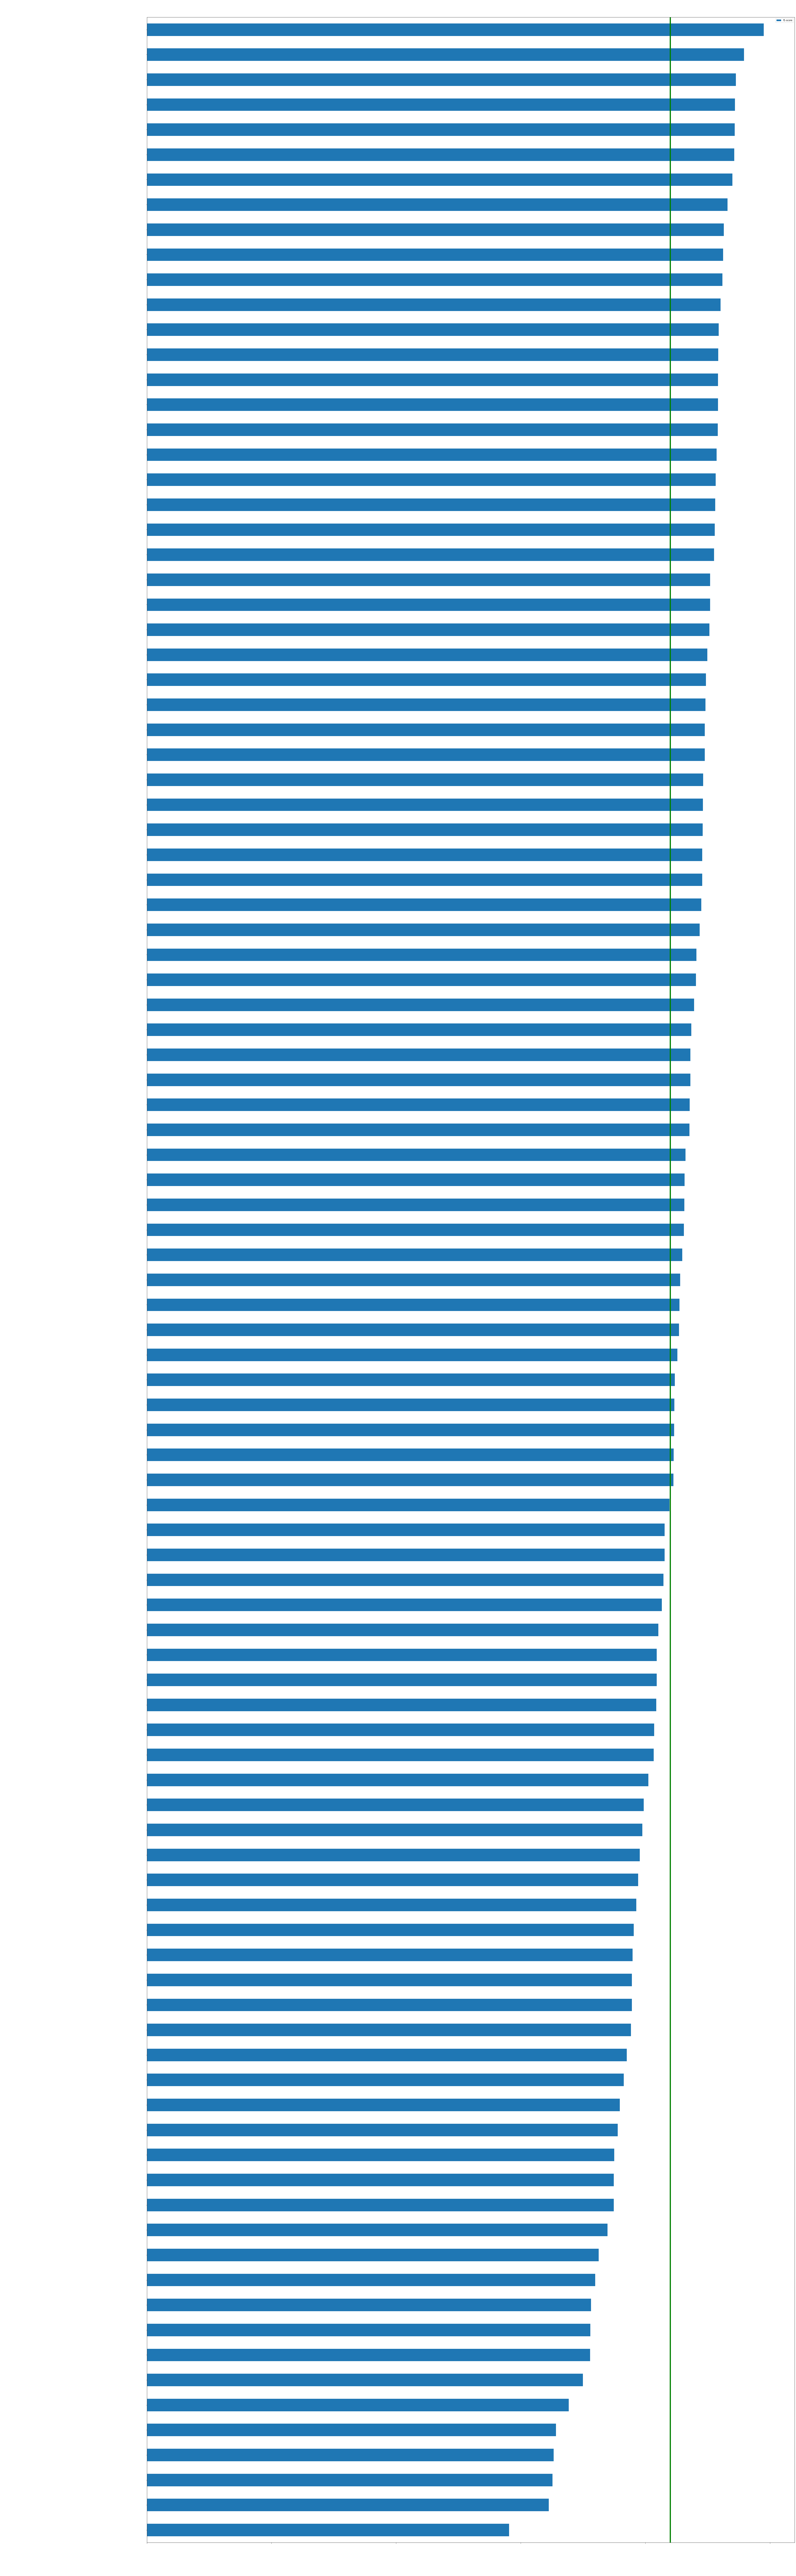

In [158]:
import matplotlib.pyplot as plt
%matplotlib inline
f1_df.plot.barh(figsize=(50, 200))
plt.yticks(size=50, c="white");
plt.xticks(size=60, c="white");
plt.axvline(x=0.84, c="green", linewidth=5.0);
plt.xlabel("F1-Score", size=70, c="white")
plt.title("F1-Score of each class", size=70, c="white");

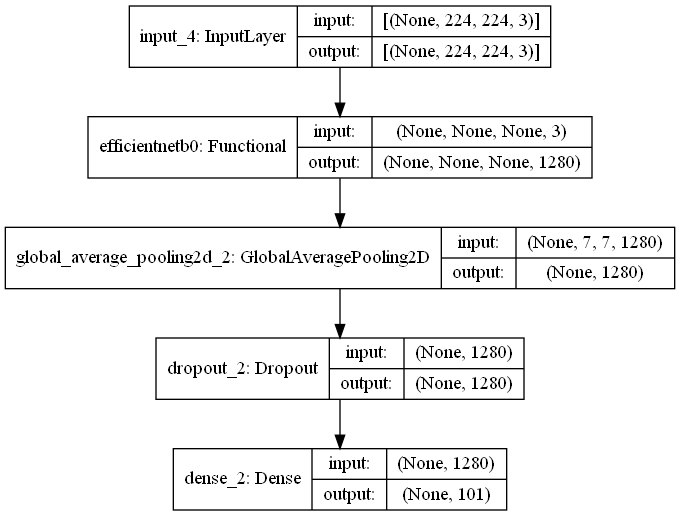

In [13]:
# Final model architecture
tf.keras.utils.plot_model(final_model, show_shapes=True)

In [15]:
# Final model summary
final_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 101)               129381    
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


## Summary

In this project I created model that achieve 84% accuracy on Food101 data set which is 7% better that original DeepFood paper's result using EfficientNetB0 architecture with few additional layers. This model is not very impressing but the point here lies somewhere else. Some random dude with his budget gaming laptop was able to achieve better results on this dataset than team of ML engineers hardware of worth XX.000 USD, few years ago. This is great showcase of TensorFlow's power.

In [35]:
def create_model_dropouts_full_training():
    input_shape = (224,224,3)
    base_model = applications.EfficientNetB0(include_top=False)

    inputs = layers.Input(shape=input_shape, dtype=tf.float32, name="input_layer")
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(101, activation="softmax")(x)

    return Model(inputs, outputs)

from tensorflow.keras.callbacks import ReduceLROnPlateau

model_12 = create_model_dropouts_full_training()
model_12.compile(
  optimizer=tf.optimizers.Adam(0.0001),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

# Create callback


In [36]:
model_12.load_weights("./checkpoints/08_food_vision/model_3/checkpoint.ckpt")

In [39]:
tf.keras.models.save_model(
    model_12, "asdf" ,
    options=tf.saved_model.SaveOptions(experimental_custom_gradients=True)
)


INFO:tensorflow:Assets written to: asdf\assets


INFO:tensorflow:Assets written to: asdf\assets
c:\MLandDS\tensorflow\env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [42]:
loadadsada = tf.keras.models.load_model("./adsafdaffs/")

In [43]:
loadadsada.evaluate(test_data)

790/790 [==============================] - 86s 105ms/step - loss: 0.6107 - accuracy: 0.0088


[0.610738217830658, 0.00879207905381918]